# Binary Classification of the "Don't Patronize Me!" Dataset

Perform Binary Classification to predict whether a text contains patronizing and condescending language. The task was task 4 (subtask 1) in the SemEval 2022 competition.

## Initialize Environment

In [1]:
# Library imports
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt    

from nltk import PorterStemmer, WordNetLemmatizer
import codecs

import torch
from torch.utils.data import DataLoader, Dataset, Sampler
from tqdm import tqdm
import torch.nn as nn

import re
from functools import partial

import numpy as np
from numpy import dot
from numpy.linalg import norm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

# Pre-trained models
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer
from transformers import BertPreTrainedModel, BertModel
from transformers.models.bert.modeling_bert import BertOnlyMLMHead
from transformers import AutoModelForSequenceClassification, AdamW, get_scheduler


def fix_seed(seed=420.69):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
#   np.random.seed(seed)
#   random.seed(seed)

fix_seed()

data_path = '../bin/data'
embeddings_path = '../bin/word_embeddings'


2024-03-02 15:48:35.343522: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-02 15:48:35.364784: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 15:48:35.364803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 15:48:35.365376: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-02 15:48:35.369220: I tensorflow/core/platform/cpu_feature_guar

In [2]:
if not torch.cuda.is_available():
  DEVICE = 'cpu'
else:
  DEVICE = 'cuda'

print(DEVICE)

cuda


In [3]:
h_params = {
    'model': 'None'
    , 'batch_size': 8
    , 'embedding_dimensions': 50
}

## Raw Data

### Loading

Load the data into pandas dataframes

In [4]:
# Import Data
train_data_path = f'{data_path}/dontpatronizeme_pcl.tsv'
test_data_path  = f'{data_path}/task4_test.tsv'

train_data = pd.read_csv(train_data_path, delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text','label'])
test_data  = pd.read_csv(test_data_path,  delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text'])

train_data = train_data.drop(['art_id'], axis=1)
test_data = test_data.drop(['art_id'], axis=1)

In [5]:
# Concatenate label information to train data
dev_label_path   = f'{data_path}/dev_semeval_parids-labels.csv'
train_label_path = f'{data_path}/train_semeval_parids-labels.csv'

dev_label   = pd.read_csv(dev_label_path, delimiter=',')
train_label = pd.read_csv(train_label_path, delimiter=',')

detailed_labels = pd.concat([dev_label, train_label], ignore_index=True, join='inner', names=['simple', 'detailed'])
train_data = pd.merge(train_data, detailed_labels, on='par_id')
train_data = train_data.rename(columns={'label_x': 'label', 'label_y': 'label_detailed'})

In [6]:
# Add Binary Classification column for ease of checking
train_data.loc[:, 'is_patronizing'] = 0
train_data.loc[train_data['label'].isin([2,3,4]), 'is_patronizing'] = 1

In [7]:
train_data = train_data.dropna(subset = 'text')
test_data = test_data.dropna(subset = 'text')

test_data['is_patronizing'] = -1
test_data

,par_id,keyword,country_code,text,is_patronizing
0,t_4,vulnerable,ca,"Members of the church , which is part of Ken C...",-1
1,t_5,women,tz,"To ensure that "" Priority Agriculture Programm...",-1
2,t_6,immigrant,us,The deportees stepped off their flight from El...,-1
3,t_7,disabled,pk,PIMS staffer who raped disabled girl at ICU wa...,-1
4,t_9,vulnerable,lk,"I conclude , Yes , the general FEELING generat...",-1
...,...,...,...,...,...
3823,t_3893,migrant,jm,In a letter dated Thursday to European Commiss...,-1
3824,t_3894,poor-families,au,They discovered that poor families with health...,-1
3825,t_3895,migrant,ca,"She married at 19 , to Milan ( Emil ) Badovina...",-1
3826,t_3896,immigrant,us,The United Kingdom is n't going to devolve int...,-1


In [8]:
keyword_set = sorted(set(train_data['keyword']))
country_set = sorted(set(train_data['country_code']))

def keyword_to_id(country:str, keyword_set=keyword_set):
    return keyword_set.index(country)

def id_to_keyword(id:int, keyword_set=keyword_set):
    assert id >= 0
    assert id < len(keyword_set)
    return keyword_set[id]

def country_to_id(country:str, country_set=country_set):
    return country_set.index(country)

def id_to_country(id:int, country_set=country_set):
    assert id >= 0
    assert id < len(country_set)
    return country_set[id]

## Pre-processing

### Masking

In [9]:
# Randomly masking tokens in a sentence as a pre-processing step
def mask_tokens(inputs, tokenizer, mlm_probability):
    """Given a tokenized input, will prepare masked tokens inputs/labels for Masked Language Modelling. 'We want to train BERT to predict an mlm_probability% of tokens (in the original paper it is 15%) of which 80% will be replaced by a ``[MASK]`` token, 10% with a random token and 10% remain the same token.' (from tutorial)"""

    assert tokenizer.mask_token is not None and "Tokenizer should not be none. (how can we mask if we don't know what to call it!)"

    labels = inputs.clone()

    # We sample a few tokens in each sequence for masked-LM training (with probability mlm_probability defaults to 0.15 in Bert/RoBERTa)
    probability_matrix = torch.full(labels.shape, mlm_probability)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)

    if tokenizer._pad_token is not None:
        padding_mask = labels.eq(tokenizer.pad_token_id)
        probability_matrix.masked_fill_(padding_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

### Data Formatting

In [10]:
# Creating Datasets for formatting entries from the PCL dataset.
class LabelledDataset(Dataset):
    def __init__(self, data_frame: pd.DataFrame):
        self.data = data_frame

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Returns a singular item with all pre-processing required for the tester"""

        data = {'keyword'     : self.data['keyword'].iloc[idx],
                'country_code': self.data['country_code'].iloc[idx],
                'text'        : self.data['text'].iloc[idx]}
        
        # instead of label and label_detailed we use is_patronizing
        label = {'is_patronizing': self.data['is_patronizing'].iloc[idx]}

        return data, label
    
    def collate_fn(batch, tokenizer, trunc_len = 300, mask = False, mlm_probability = 0.15):
        """merges a list of samples to form a mini-batch of Tensor(s). Used when using batched loading from a map-style"""

        encodings = []

        input_features = [i for i, _ in batch]
        output_labels  = [o for _, o in batch]    

        # 1. We pad shorter sentences to a length of trunc_len tokens since the maximum sequence size for BERT is 512
        batched_text = [item['text'] for item in input_features]
        encodings    = tokenizer(batched_text, return_tensors='pt', padding=True, truncation=True, max_length=trunc_len)

        ## 1.1 Optionally, mask some entries of the tokenized input
        if mask:
            masked_input, labels = mask_tokens(encodings['input_ids'], tokenizer, mlm_probability)
            encodings['input_ids'] = masked_input
            encodings['labels'] = labels

        # As a final task we also process the output labels into a tensor
        encodings['labels'] = torch.tensor([item['is_patronizing'] for item in output_labels])
        return encodings

# class WithheldDataset(Dataset):
#     def __init__(self, data_frame: pd.DataFrame):
#         self.data = data_frame
    
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         data = {'keyword'     : self.data['keyword'].iloc[idx],
#                 'country_code': self.data['country_code'].iloc[idx],
#                 'text'        : self.data['text'].iloc[idx]}
        
#         return data
    
#     def collate_fn(batch, tokenizer, trunc_len = 300):
#         """merges a list of samples to form a mini-batch of Tensor(s). Used when using batched loading from a map-style"""

#         encodings = []
#         input_features = batch

#         # 1. We pad shorter sentences to a length of trunc_len tokens since the maximum sequence size for BERT is 512
#         batched_text = [item['text'] for item in input_features]
#         encodings    = tokenizer(batched_text, return_tensors='pt', padding=True, truncation=True, max_length=trunc_len)

#         return encodings

## Data Splits

split the data whilst keeping distributions of country, text and is_patronizing counts even

In [11]:
def pie_data_distributions(pie_series, pie_series_label):
    """Plots some pie charts for data distribution (Assume len(pie_series) inputs)

    Args:
        pie_series (_type_): pandas series 
        pie_series_label (_type_): for the title
    """

    assert len(pie_series) == len(pie_series_label) and "expected inputs of same length"

    _, axs = plt.subplots(1, len(pie_series), figsize=(len(pie_series)*5, 5))

    for idx, (series, title) in enumerate(zip(pie_series, pie_series_label)):
        tmp = series.value_counts()

        wedges, _, _ = axs[idx].pie(tmp, labels=tmp.index, autopct='%1.1f%%', startangle=90)
        legend_labels = [f'{label} ({count})' for label, count in zip(tmp.index, tmp)]
        axs[idx].legend(wedges, legend_labels, title="Class 1 and 0", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
        axs[idx].set_title(f'Distribution for {title}')

    plt.tight_layout()
    plt.show()

In [12]:
def generate_data_splits(train_data):
    # The stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify. 

    X_train, X_val, y_train, y_val = train_test_split(train_data[['text', 'keyword', 'country_code']]
                                                    , train_data['is_patronizing']
                                                    , train_size=0.8
                                                    , test_size=0.2
                                                    , random_state=0
                                                    , stratify=train_data[['is_patronizing']]
                                                    )
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape : {X_val.shape}")
    print(f"y_test shape : {y_val.shape}")
    print()
    print("=== DISTRIBUTION FOR TRAINING DATA ===")
    pie_data_distributions(
        [X_train['country_code'], X_train['keyword'], y_train],
        ['train country_code label', 'train keyword label', 'train binary classification']
    )

    print("=== DISTRIBUTION FOR VALIDATION DATA ===")
    pie_data_distributions(
        [X_val['country_code'], X_val['keyword'], y_val],
        ['validation country_code label', 'validation keyword label', 'validation binary classification']
    )

    print("=== DISTRIBUTION FOR TEST DATA ===")
    pie_data_distributions(
        [test_data['country_code'], test_data['keyword']],
        ['test country_code label', 'test keyword label']
    )

    return X_train, X_val, y_train, y_val

### Distribution before Minority oversampling and Majority Undersampling

X_train shape: (8374, 3)
y_train shape: (8374,)
X_test shape : (2094, 3)
y_test shape : (2094,)

=== DISTRIBUTION FOR TRAINING DATA ===


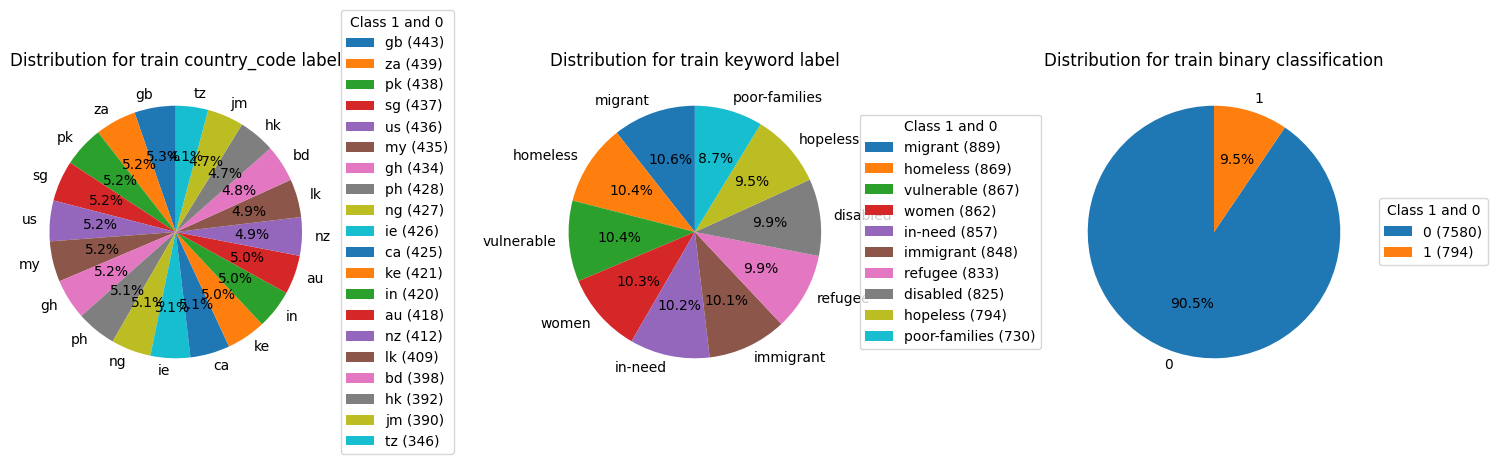

=== DISTRIBUTION FOR VALIDATION DATA ===


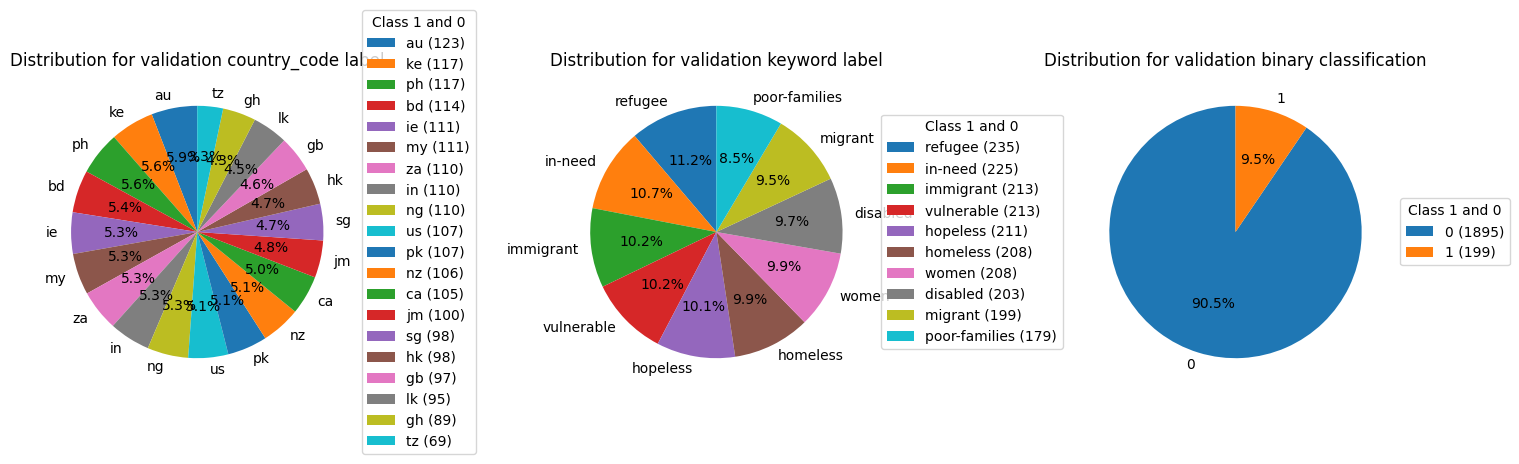

=== DISTRIBUTION FOR TEST DATA ===


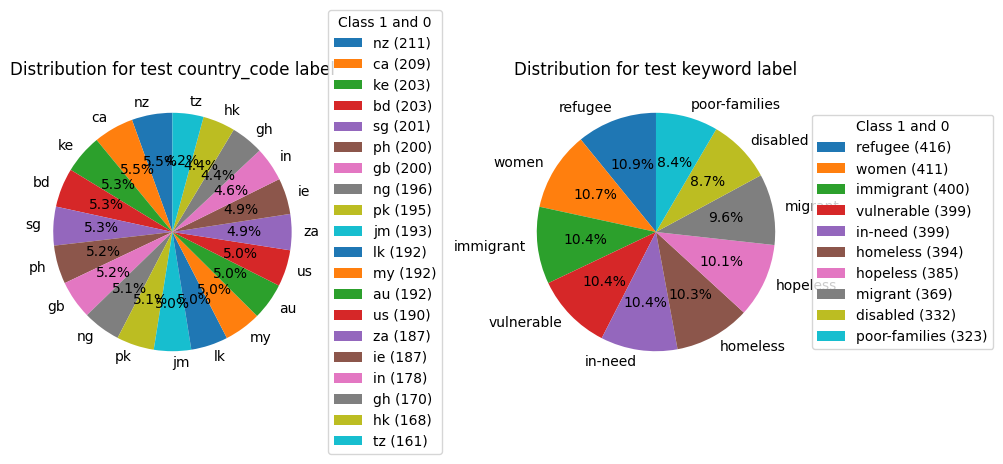

In [13]:
X_train, X_val, y_train, y_val = generate_data_splits(train_data)

### Up-sample the Minority Class

(Initially) Inspired by https://datascience.stackexchange.com/questions/27671/how-do-you-apply-smote-on-text-classification 

Code implemented from https://arxiv.org/pdf/1901.11196.pdf

In [14]:
!git clone https://github.com/jasonwei20/eda_nlp.git
from eda_nlp.code.eda import *

fatal: destination path 'eda_nlp' already exists and is not an empty directory.


In [15]:
# Default parameters have shown good performance in the original paper
eda("I hate you because I think that I'm better than you", alpha_ri=0.0, num_aug=5)

['i hatred you because i think that im better than you',
 'hate because i think that im better than you',
 'i because you hate i think that im better than you',
 'i hate you because i think that im better than you',
 'i hatred you because i think that im better than you',
 'i hate you because i think that im better than you']

In [16]:
num_aug = 2

eda_upsampled = train_data[train_data['is_patronizing'] == 1]
eda_upsampled.loc[:, 'text'] = eda_upsampled.apply(lambda row: eda(row['text'], alpha_ri=0.0, num_aug=num_aug), axis=1)

upsampled_positives = pd.DataFrame(columns=train_data.columns)

for _, row in eda_upsampled.iterrows():
    for upsample in row['text']:
        # insert into upsampled_positives the row['text'] and the remaining columns in variable row
        new_row = pd.DataFrame([row], columns=train_data.columns)
        new_row['text'] = upsample
        upsampled_positives = pd.concat([upsampled_positives, new_row], ignore_index=True)

train_data_minority_upsampled = pd.concat([upsampled_positives, train_data[train_data['is_patronizing'] == 0]], ignore_index=True)

X_train shape: (9963, 3)
y_train shape: (9963,)
X_test shape : (2491, 3)
y_test shape : (2491,)

=== DISTRIBUTION FOR TRAINING DATA ===


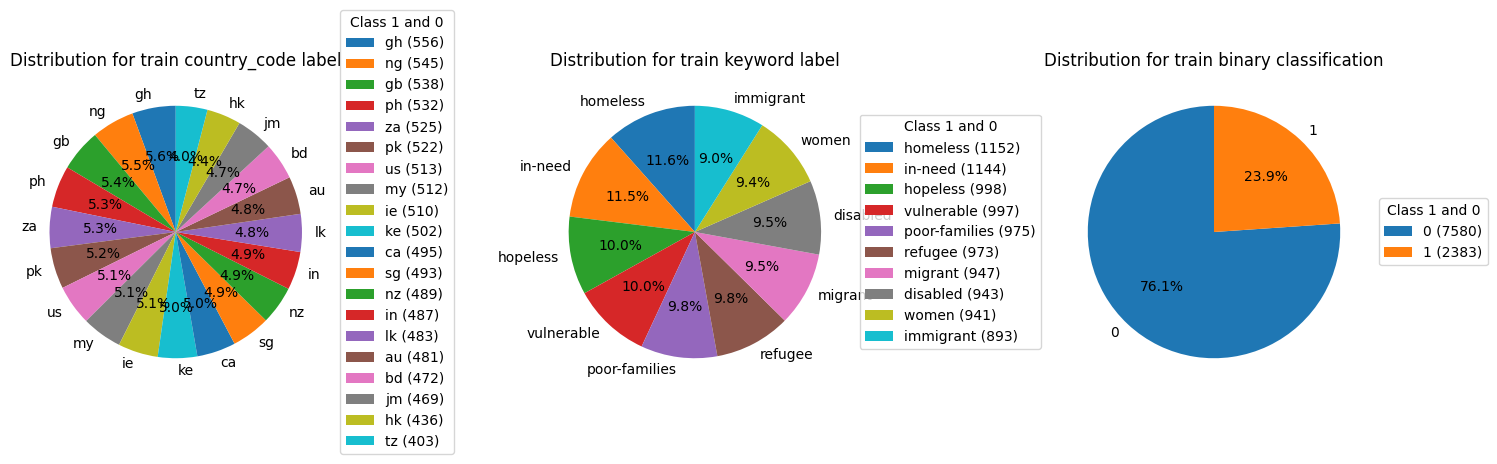

=== DISTRIBUTION FOR VALIDATION DATA ===


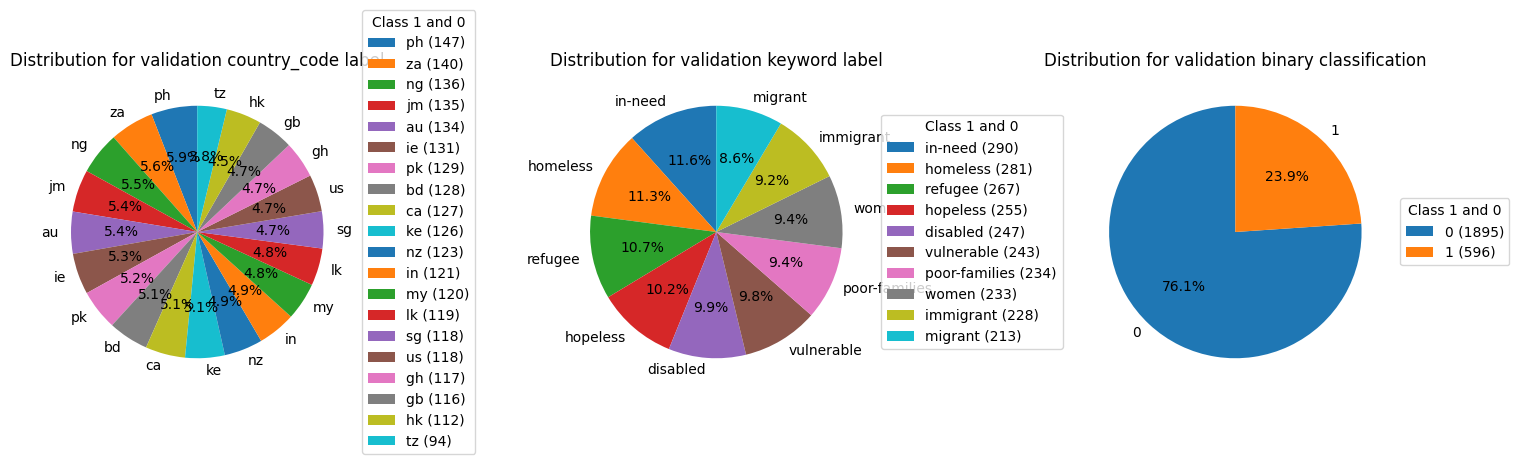

=== DISTRIBUTION FOR TEST DATA ===


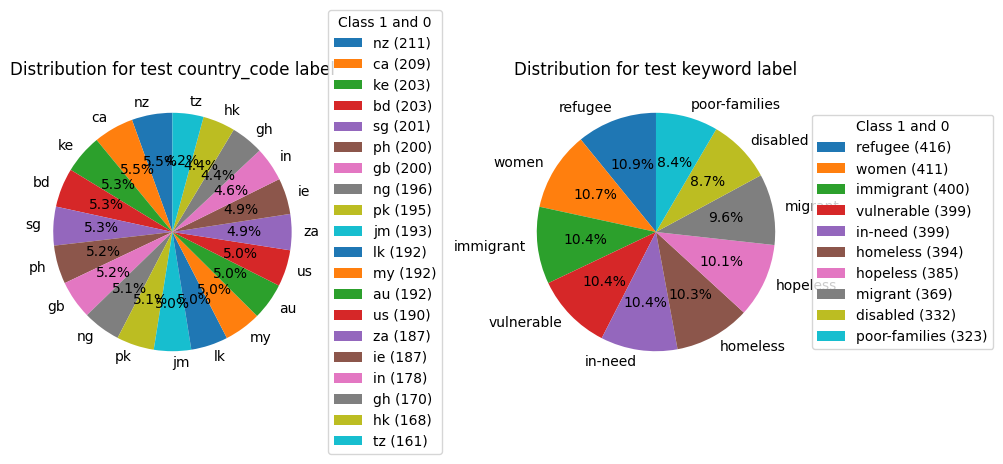

In [17]:
X_train, X_val, y_train, y_val = generate_data_splits(train_data_minority_upsampled)

In [18]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# bert was trained on unpublished books, might be better to train on social media where typos are more common?

# Set up DataLoaders for test, validation and training
sampled_train_data = pd.merge(X_train, y_train, left_index=True, right_index=True)
sampled_val_data = pd.merge(X_val, y_val, left_index=True, right_index=True)

test_dataset = LabelledDataset(test_data)
training_dataset = LabelledDataset(sampled_train_data)
val_dataset = LabelledDataset(sampled_val_data)

In [19]:
%%script false --no-raise-error
# don't execute this cell whilst running final submission

for batch in DataLoader(test_dataset, batch_size=2):
  break

print(batch)

In [20]:
%%script false --no-raise-error
# don't execute this cell whilst running final submission

for batch in DataLoader(training_dataset, batch_size=2):
    break

print(batch)

## Evaluation

In [21]:
def performance_metrics(model, dataloader):
    """Given a model's predicted output, and its corresponding expected output, generates performance metrics and confusion matrix"""

    predicted = []
    expected = []

    input_features = dataloader.data['text'].tolist()
    predictions, _ = model.predict(input_features)
    
    expected = np.array(dataloader.data['is_patronizing'])
    expected = expected.astype(int)

    print(classification_report(expected, predictions))

    set(predicted)
    cm = confusion_matrix(expected, predictions, labels=[0, 1]) 

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True));  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

    ax.set_title('Confusion Matrix')

    ax.xaxis.set_ticklabels(['Not Patronizing', 'Patronizing'])
    ax.yaxis.set_ticklabels(['Not Patronizing', 'Patronizing'])

In [22]:
def model_prediction(model):
    """Given a model and input for the forward pass, will output pretty-printed output"""
    # Get one random sample from the test data
    random_index = X_val.sample(n=1).index.values[0]

    while random_index not in train_data.index:
        random_index = X_val.sample(n=1).index.values[0]

    # Extract random sample
    tdf = train_data.loc[[random_index]][['text', 'is_patronizing']]
    test_paragraph, real_label = tdf['text'].values[0], tdf['is_patronizing'].values[0]

    # Get model prediction
    predicted_label, _ = model.predict([tdf['text'].values[0]])

    print(f"=== Paragraph example ===\n{test_paragraph.capitalize()}")
    print(f"\tReal Label:      {real_label}")
    print(f"\tModel Prediction:{predicted_label[0]}")


## Model

In [23]:
class BERT_hate_speech(BertPreTrainedModel):

    def __init__(self, config):
        super().__init__(config)

        # BERT Model
        self.bert = BertModel(config)

        # Task A
        self.projection = torch.nn.Sequential(torch.nn.Dropout(0.2),
                                              torch.nn.Linear(config.hidden_size, 1),
                                              torch.nn.Sigmoid())

        self.init_weights()

    def forward( 
        self, 
        input_ids=None, 
        attention_mask=None, 
        token_type_ids=None, 
        position_ids=None, 
        head_mask=None, 
        inputs_embeds=None, 
        labels=None, 
        output_attentions=None, 
        output_hidden_states=None, 
        return_dict=None):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # Logits A
        logits_a = self.projection(outputs[1])

        return logits_a


In [24]:
class MyTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        output = model(**inputs)
        output = output.clamp(min=1e-6, max=1-1e-6)
        output = output.squeeze()
        
        loss = nn.BCELoss()(output, inputs['labels'].squeeze().float())
        
        if return_outputs:
            return loss, output
        else:
            return loss


In [25]:
model = BERT_hate_speech.from_pretrained('bert-base-cased')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    # per_device_train_batch_size=16,
    # per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = MyTrainer(
    model=model,
    args=training_args,
    train_dataset=training_dataset,
    eval_dataset=val_dataset,
    data_collator=partial(LabelledDataset.collate_fn, tokenizer=tokenizer),
)

Some weights of BERT_hate_speech were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['projection.1.bias', 'projection.1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anton-zhitomirsky (anton-zhitomirsky-joe-mama). Use `wandb login --relogin` to force relogin


 20%|██        | 502/2492 [00:50<03:16, 10.11it/s]

{'loss': 0.0552, 'grad_norm': 0.005058674607425928, 'learning_rate': 1.5987158908507224e-05, 'epoch': 0.4}


 40%|████      | 1002/2492 [01:40<02:48,  8.83it/s]

{'loss': 0.0062, 'grad_norm': 0.0030795158818364143, 'learning_rate': 1.1974317817014447e-05, 'epoch': 0.8}


                                                   
 50%|█████     | 1246/2492 [02:13<02:13,  9.34it/s]

{'eval_loss': 5.991264697513543e-05, 'eval_runtime': 6.9743, 'eval_samples_per_second': 357.168, 'eval_steps_per_second': 44.736, 'epoch': 1.0}


 60%|██████    | 1502/2492 [02:40<01:38, 10.07it/s]

{'loss': 0.0023, 'grad_norm': 0.003452499397099018, 'learning_rate': 7.961476725521669e-06, 'epoch': 1.2}


 80%|████████  | 2001/2492 [03:30<00:47, 10.36it/s]

{'loss': 0.0001, 'grad_norm': 0.0011121222050860524, 'learning_rate': 3.948635634028893e-06, 'epoch': 1.61}


                                                   
100%|██████████| 2492/2492 [04:27<00:00, 10.86it/s]

{'eval_loss': 3.438412750256248e-05, 'eval_runtime': 6.9871, 'eval_samples_per_second': 356.514, 'eval_steps_per_second': 44.654, 'epoch': 2.0}


100%|██████████| 2492/2492 [04:28<00:00,  9.29it/s]

{'train_runtime': 269.5932, 'train_samples_per_second': 73.911, 'train_steps_per_second': 9.244, 'train_loss': 0.012825766484138001, 'epoch': 2.0}


TrainOutput(global_step=2492, training_loss=0.012825766484138001, metrics={'train_runtime': 269.5932, 'train_samples_per_second': 73.911, 'train_steps_per_second': 9.244, 'train_loss': 0.012825766484138001, 'epoch': 2.0})

In [64]:
def predict_PCL(text, model, tokenizer):
    model.eval()
    encodings = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=300)
    
    encodings.to(DEVICE)

    output = model(**encodings)
    
    return output

predict_PCL(["I hate you"], model, tokenizer)


# print(prediction)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [53]:
performance_metrics(model, val_dataset)

AttributeError: 'BERT_hate_speech' object has no attribute 'predict'

In [ ]:

task1_model_args = ClassificationArgs(num_train_epochs=10,
                                      no_save=True,
                                      no_cache=True,
                                      overwrite_output_dir=True,
                                      use_multiprocessing = False,
                                      use_multiprocessing_for_evaluation = False,
                                      learning_rate=2e-5,
                                      output_dir='my_awesome_model',
                                      save_steps='epoch',
                                      )

task1_model = ClassificationModel("roberta",
                                  'roberta-base',
                                  args = task1_model_args,
                                  num_labels=2,
                                  use_cuda=torch.cuda.is_available())

# train model
task1_model.train_model(training_dataset.data[['text', 'is_patronizing']])

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
Epoch 7 of 10:  60%|██████    | 6/10 [09:11<06:07, 91.87s/it]


KeyboardInterrupt: 

In [ ]:
preds_task1, _ = task1_model.predict(test_dataset.data['text'].tolist())

100%|██████████| 39/39 [00:05<00:00,  7.13it/s]


In [ ]:
from collections import Counter
Counter(preds_task1)

Counter({0: 3789, 1: 39})

100%|██████████| 21/21 [00:03<00:00,  6.89it/s]


              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1895
           1       0.70      0.11      0.18       199

    accuracy                           0.91      2094
   macro avg       0.81      0.55      0.57      2094
weighted avg       0.89      0.91      0.88      2094



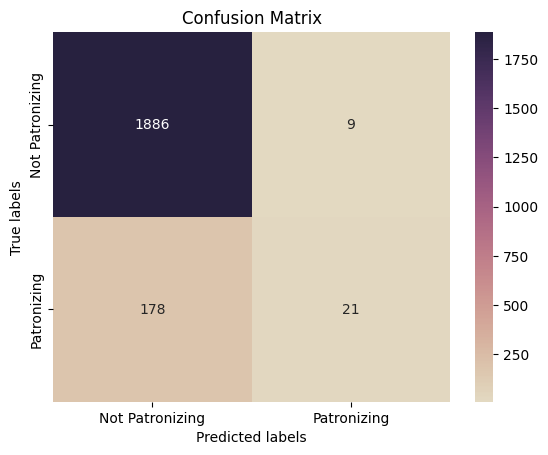

In [ ]:
performance_metrics(task1_model, val_dataset)

### Vanilla Model

In [ ]:

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=5e-5)

train_model(model, optimizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 1965/1965 [04:49<00:00,  6.80it/s]


100%|██████████| 193/193 [00:09<00:00, 20.56batch/s]

              precision    recall  f1-score   support

           0       0.65      0.99      0.79      1895
           1       0.93      0.15      0.26      1192

    accuracy                           0.67      3087
   macro avg       0.79      0.57      0.53      3087
weighted avg       0.76      0.67      0.58      3087



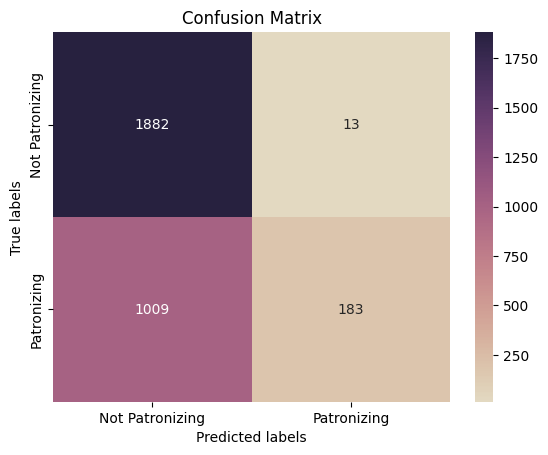

### Some other Model

In [ ]:
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=3e-5)

train_model(model, optimizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


3927


100%|██████████| 3927/3927 [04:57<00:00, 13.19it/s]


              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1895
           1       0.66      0.15      0.24       199

    accuracy                           0.91      2094
   macro avg       0.79      0.57      0.60      2094
weighted avg       0.89      0.91      0.89      2094



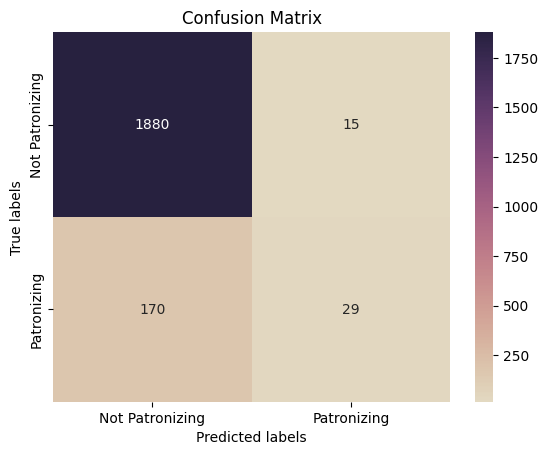

In [ ]:
performance_metrics(model, val_loader)

### With Accelerator

In [ ]:
from accelerate import Accelerator
from transformers import AdamW, AutoModelForSequenceClassification, get_scheduler

accelerator = Accelerator()

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
optimizer = AdamW(model.parameters(), lr=3e-5)

train_dl, eval_dl, model, optimizer = accelerator.prepare(
    train_loader, val_loader, model, optimizer
)

train_model(model, optimizer, train_loader=train_dl, accelerator=accelerator)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


3927


100%|██████████| 3927/3927 [20:17<00:00,  3.23it/s]


              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1895
           1       0.00      0.00      0.00       199

    accuracy                           0.90      2094
   macro avg       0.45      0.50      0.48      2094
weighted avg       0.82      0.90      0.86      2094



/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

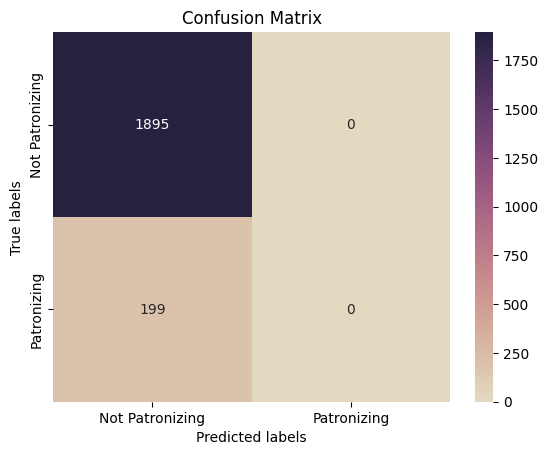

In [ ]:
performance_metrics(model, val_loader)

### My custom layer

## Submission Documents

In [ ]:
def get_and_save_predictions(dataset, save_name, model=task1_model):
    y_pred, _ = model.predict(dataset.tolist())
    np.savetxt(f'{save_name}.txt', y_pred, fmt='%d')

# train predictions
get_and_save_predictions(test_data['text'], "test")

# test predictions
get_and_save_predictions(train_data['text'], "dev")

100%|██████████| 105/105 [00:14<00:00,  7.19it/s]
